# Comparison of Time Series, Machine Learning and Deep Learning models

## 1. Introduction

Various models will be explored to forecast Adjusted Close prices for AstraZeneca stock price data from simple machine learning algorithms such as Moving Average, Linear Regression and k-Nearest Neighbours, to Auto ARIMA, Facebook's Prophet and LSTM.  


## 2. Install/import libraries

In [ ]:
!pip install yfinance as yfinance
!pip install pmdarima
!pip install fbprophet

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pmdarima import auto_arima

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta





Read in AstraZeneca stock data downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame. 

In [3]:
azn_df = yf.download("AZN.L", start="2010-01-01", end="2020-01-01")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


In [4]:
azn_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2009-12-31,1681.68,2913.5,2929.0,2892.00,2910.5,606488
2010-01-04,1699.30,2912.0,2946.0,2912.00,2941.0,2091679
2010-01-05,1679.94,2936.0,2949.5,2901.00,2907.5,2869739
2010-01-06,1661.16,2909.0,2909.0,2850.50,2875.0,3136541
2010-01-07,1681.68,2879.0,2925.5,2879.00,2910.5,3748200
...,...,...,...,...,...,...
2019-12-23,7210.13,7771.0,7824.0,7723.87,7746.0,2183949
2019-12-24,7180.35,7715.0,7794.0,7631.29,7714.0,378885
2019-12-27,7209.20,7706.0,7781.0,7641.00,7745.0,862283


In [6]:
# Create DataFrame for Adjusted Close price

azn_adj = azn_df[['Adj Close']]
azn_adj 

,Adj Close
Date,
2009-12-31,1681.68
2010-01-04,1699.30
2010-01-05,1679.94
2010-01-06,1661.16
2010-01-07,1681.68
...,...
2019-12-23,7210.13
2019-12-24,7180.35
2019-12-27,7209.20



### Split the data

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [7]:
# Creating 80%/20% split

split = int(0.8*len(azn_adj))

In [8]:
# Splitting into train and test

train, test = azn_adj[:split], azn_adj[split:]

In [9]:
azn_adj.shape, train.shape, test.shape

((2527, 1), (2021, 1), (506, 1))

In [10]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2009-12-31 00:00:00'),
 Timestamp('2017-12-29 00:00:00'),
 Timestamp('2018-01-02 00:00:00'),
 Timestamp('2019-12-31 00:00:00'))

### Create predictions for the test set

In [15]:
# Make predictions
preds = []
for i in range(0,506):
    a = train[len(train)-506+i:].sum() + sum(preds)
    b = a/504
    preds.append(b)

### Calculate the RMSE using the actual values



In [16]:
# Calculate rmse
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

1616.1672222763923

## 7. Auto ARIMA

Auto Regressive Integrated Moving Average (ARIMA) models explains a given time series based on its own past values, that is, its own lags (p) and the lagged forecast errors (q), so that equation can be used to forecast future values. The 'd' parameter represents the number of times that the data have to be differenced to produce a stationary signal that has a constant mean over time. This captures the integrated nature of ARIMA.

Auto ARIMA automatically generates the optimal combination of (p,q,d) which would be suitable for the data set to provide better forecasting.

In [18]:
# Create Adjusted Close price DataFrame

azn_adj = azn_df[['Adj Close']]
azn_adj 

,Adj Close
Date,
2009-12-31,1681.68
2010-01-04,1699.30
2010-01-05,1679.94
2010-01-06,1661.16
2010-01-07,1681.68
...,...
2019-12-23,7210.13
2019-12-24,7180.35
2019-12-27,7209.20


### Split the data into train and test sets

In [19]:
split = int(0.8*len(azn_adj))

In [20]:
train, test = azn_adj[:split], azn_adj[split:]

In [21]:
azn_adj.shape, train.shape, test.shape

((2527, 1), (2021, 1), (506, 1))

### Create, train and test model

In [22]:
# Create model to find best parameters
model = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
# Train model
model.fit(train)
# Make predictions on test set
forecast = model.predict(n_periods=506)
# Create DataFrame for Predictions
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=22188.162, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21647.306, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=22189.784, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=21397.230, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=21395.242, Time=1.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=21645.627, Time=0.34 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.86 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=21397.230, Time=1.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=21399.220, Time=1.61 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AI

### Calculate the RMSE using the actual values

In [28]:
rmse = np.sqrt(np.mean(np.power((np.array(test['Adj Close'])-np.array(forecast['Prediction'])),2)))
print('R^2 score: {}'.format(round(r2_score(forecast['Prediction'], test['Adj Close']), 3)))
rmse

R^2 score: 0.764


397.1243762237044

### Print results and plot residuals of optimised model

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2527
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -13522.446
Date:                Tue, 09 Aug 2022   AIC                          27046.893
Time:                        23:42:37   BIC                          27052.727
Sample:                             0   HQIC                         27049.010
                               - 2527                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2613.2123     20.889    125.097      0.000    2572.270    2654.155
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             55121.50
Prob(Q):                              0.55   Pr

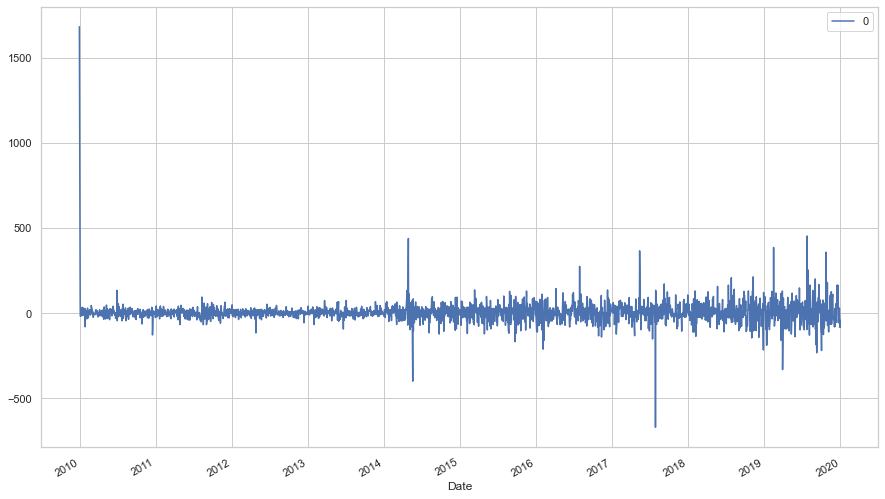

In [31]:
# Create model with best parameters and print results
model = ARIMA(azn_adj['Adj Close'], order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot();

In [ ]:
print('R^2 score: {}'.format(round(r2_score(forecast1, test['Adj Close']), 3)))

### Visualise predicted values along with the actual values

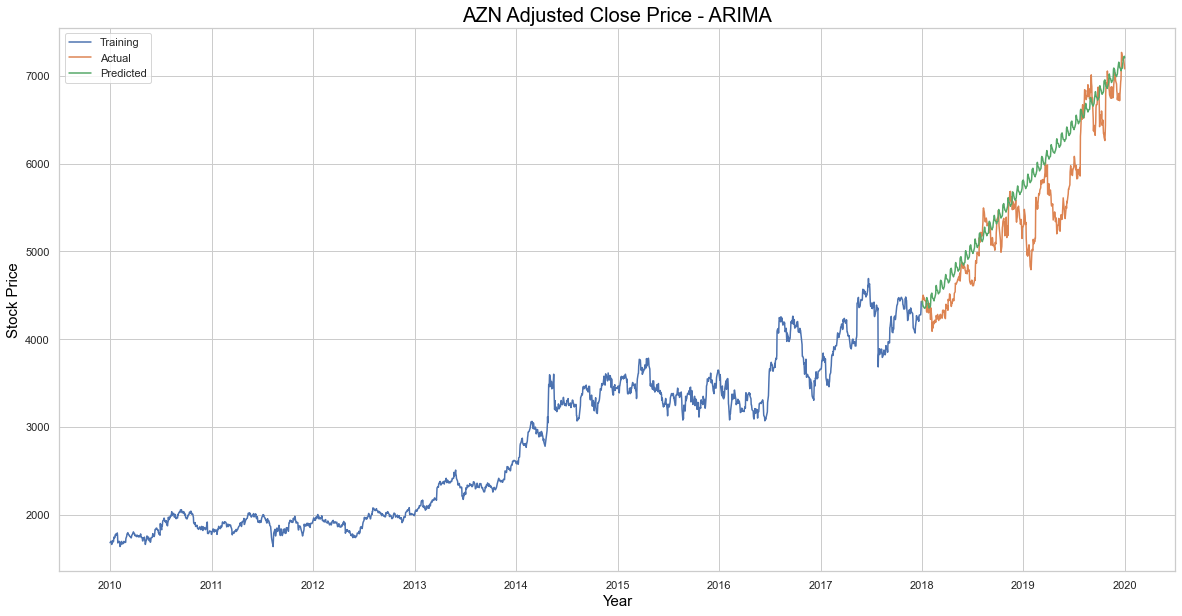

In [26]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(forecast['Prediction'], label='Predicted')
plt.title("AZN Adjusted Close Price - ARIMA", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();